In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv


The following data exploration is inspired by https://www.kaggle.com/pmarcelino/comprehensive-data-exploration-with-python notebook.

# Data import and the target

Import the training set as well as the used libraries

In [2]:
# Import common libraries (besides np and pd)
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from scipy import stats
from scipy.stats import norm

pd.set_option('display.max_columns', 100)

df_train = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/train.csv")

Data exploration begins here

In [3]:
# Retrieve all the provided features
df_train.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

1. Investigate the SalePrice variable. It is the value, we need to predict.

In [4]:
df_train['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

Histogram and investigation of normality is next:

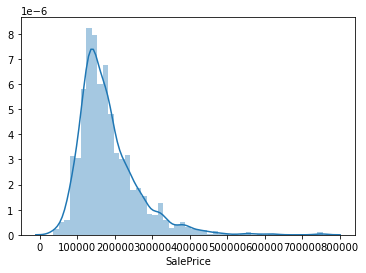

In [5]:
sns.distplot(df_train['SalePrice'])

* 1460 counts with a mean of 180931 USD and a std of 79442 USD. 
* A right skewed distribution with a distinct peak is seen. 

In [6]:
print(df_train["SalePrice"].skew())
print(df_train["SalePrice"].kurt())

1.8828757597682129
6.536281860064529


A very considarable skewness and kurtosis (positve => way more in tails than norm. dist => leptokurtic dist.) shows that sale prices do not follow a normal dist.

# Analysis of expected high importance features

After looking into all the provided features, I select following as highly important:

Continuos
1. LotArea
2. GrLivArea
3. TotalBsmtSF

Categorical
1. OverallCond
2. OverallQual
3. Neighborhood
4. YrSold
5. YearBuilt
6. YearRemodAdd


## Continuos variables

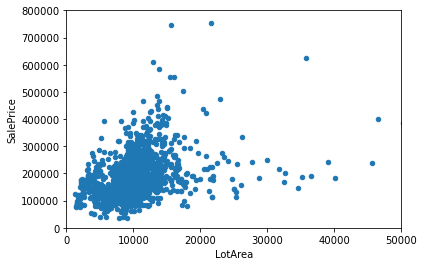

In [7]:
#scatter plot YrSold/saleprice
var = "LotArea"
data = pd.concat([df_train['SalePrice'], df_train[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(0,800000), xlim=(0,50000))

LotArea and SalePrice correlates to lesser degree. I have limited LotArea to 50000 sq. feet due to a suspision that some of the large area properties are industrial. (to be investigated)

RL         1151
RM          218
FV           65
RH           16
C (all)      10
Name: MSZoning, dtype: int64

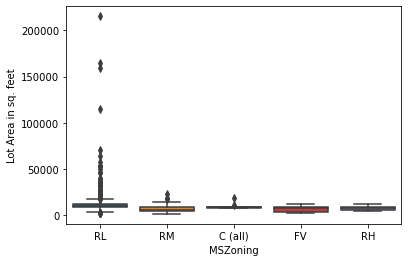

In [8]:
#data = pd.concat([df_train['LotArea'], df_train['MSZoning']], axis=1)
#bp = sns.boxplot(data=data.loc[:, ["BPXSY1", "BPXSY2", "BPXDI1", "BPXDI2"]])

bp = sns.boxplot(x="MSZoning", y="LotArea", data=df_train)
_ = bp.set_ylabel("Lot Area in sq. feet")
df_train["MSZoning"].value_counts()

"MSZoning: Identifies the general zoning classification of the sale."

It seems that the abnormally large lot areas are placed in RL (Residental low density), not in the industrial (which is actually not even there).

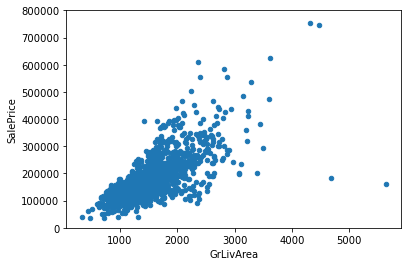

In [9]:
#scatter plot GrLivArea/saleprice
var = "GrLivArea"
data = pd.concat([df_train['SalePrice'], df_train[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(0,800000))

Strong linear relationship between GrLivArea and SalePrice

37

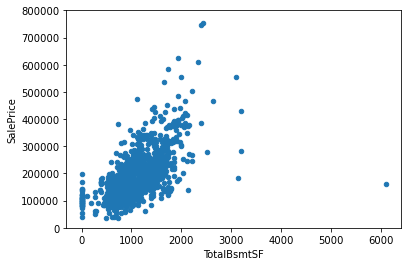

In [10]:
#scatter plot TotalBsmtSF/saleprice
var = "TotalBsmtSF"
data = pd.concat([df_train['SalePrice'], df_train[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(0,800000))
len(df_train[df_train[var] == 0])

Similar story as for lotarea. Although, not so many outliers. 37 sales with no basement area are present.

## Categorical variables

(-0.5, 8.5, 0.0, 800000.0)

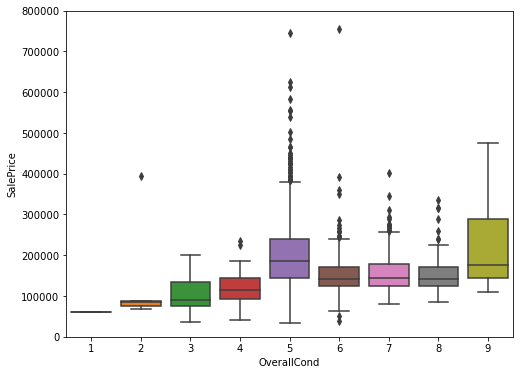

In [11]:
#box plot overallcond/saleprice
var = "OverallCond"
data = pd.concat([df_train["SalePrice"], df_train[var]], axis = 1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000)

A lot of outliers. But good correlation.

(-0.5, 9.5, 0.0, 800000.0)

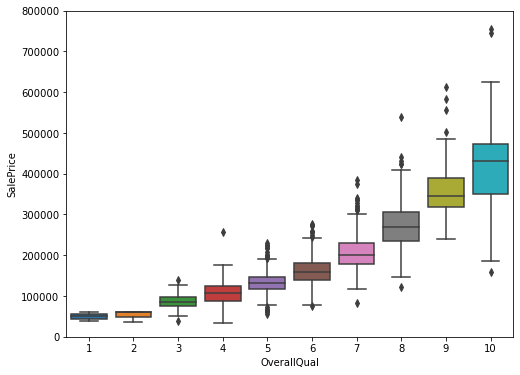

In [12]:
#box plot overallqual/saleprice
var = "OverallQual"
data = pd.concat([df_train["SalePrice"], df_train[var]], axis = 1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000)

Strong correlation.

(-0.5, 24.5, 0.0, 800000.0)

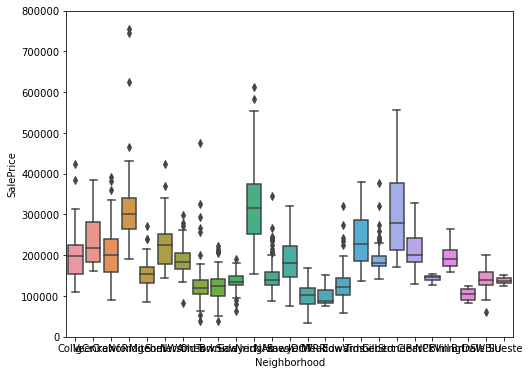

In [13]:
#box plot Neighborhood/saleprice
var = "Neighborhood"
data = pd.concat([df_train["SalePrice"], df_train[var]], axis = 1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000)

Neighberhood in some places, can predict the saleprice pretty well.

2009    338
2007    329
2006    314
2008    304
2010    175
Name: YrSold, dtype: int64

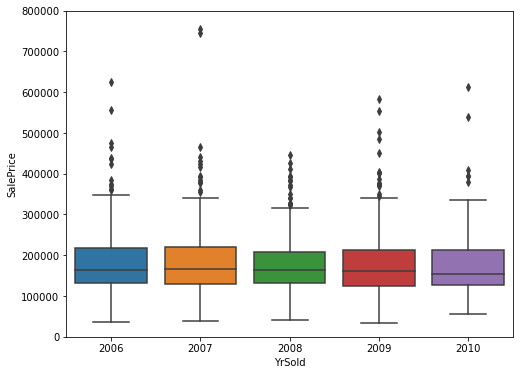

In [14]:
#box plot YrSold/saleprice
var = "YrSold"
data = pd.concat([df_train["SalePrice"], df_train[var]], axis = 1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000)
df_train[var].value_counts()

Year sold has no approx. no influence. (even though financial crisis occured from 2008-.

(-0.5, 111.5, 0.0, 800000.0)

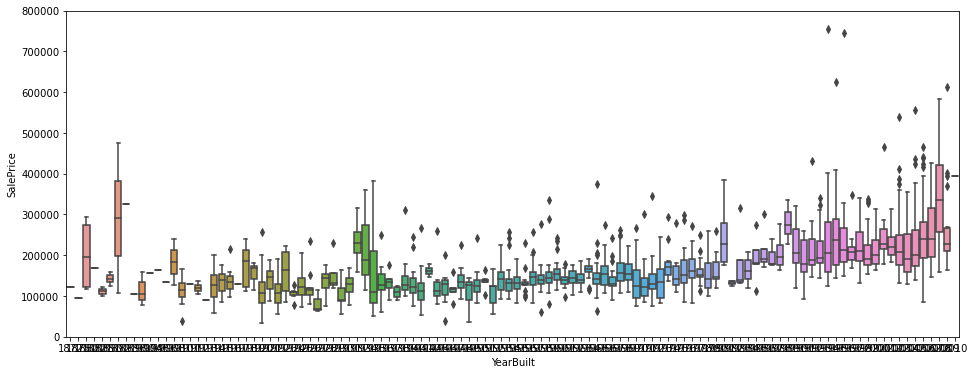

In [15]:
var = "YearBuilt"
data = pd.concat([df_train["SalePrice"], df_train[var]], axis = 1)
f, ax = plt.subplots(figsize=(16, 6))
fig = sns.boxplot(x=var, y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000)

(-0.5, 60.5, 0.0, 800000.0)

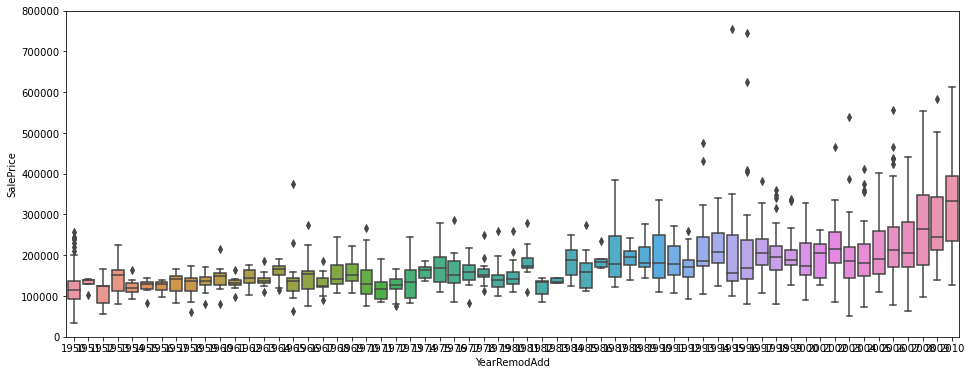

In [16]:
var = "YearRemodAdd"
data = pd.concat([df_train["SalePrice"], df_train[var]], axis = 1)
f, ax = plt.subplots(figsize=(16, 6))
fig = sns.boxplot(x=var, y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000)

YearRemodAdd and YearBuilt show a mild tendency.

# More objective approach to data exploration

Draw correlation matrix (heatmap)

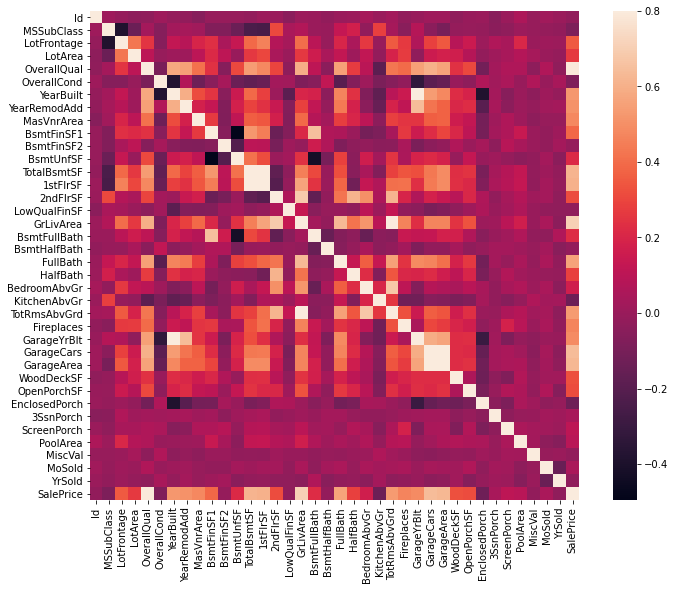

In [17]:
#Correlation matrix
corrmat = df_train.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True)

Seceral variables excibiting multicollinearity is occuring (fx GarageArea and GarageCars or GarageYrBlt and YearBuilt). 

Next is to zoom in on our taget value and look on 10 most correlated values with SalePrice.

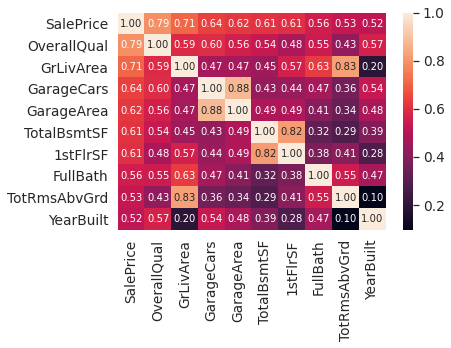

In [18]:
#saleprice correlation matrix
k = 10 #number of var for heatmap
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(df_train[cols].values.T)
sns.set(font_scale = 1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, fmt='.2f', annot_kws={'size': 10}, 
                 yticklabels=cols.values, xticklabels=cols.values)
plt.show()

Take away features:
* OverallQual
* GrLivArea (since TotRmsAbvGrd is dependant of GrLivArea)
* GarageCars (since GarageArea is dependant of GarageCars)
* TotalBsmtSF (since 1stFloor is dependant of TotalBsmtSF)
* FullBath
* YearBuilt

Now scatterplots of these features

In [19]:
#scatter pair plots
sns.set()
cols = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath', 'YearBuilt']
#sns.pairplot(df_train[cols], height = 2.5)
#plt.show()

It is seen that on some occasians GrLivArea = TotalBsmtSF (due to basement area may be equal to ground living area).
It is also seen that Saleprice and YearBuilt may have a slightly exp relationship. Prices are accelerating with years.

# Missing data analysis

In [20]:
#missing data
total = df_train.isnull().sum().sort_values(ascending=False)
percent = (df_train.isnull().sum()/df_train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
PoolQC,1453,0.995205
MiscFeature,1406,0.963014
Alley,1369,0.937671
Fence,1179,0.807534
FireplaceQu,690,0.472603
LotFrontage,259,0.177397
GarageCond,81,0.055479
GarageType,81,0.055479
GarageYrBlt,81,0.055479
GarageFinish,81,0.055479


We'll delete variables with more than 15% missing - we are probably safe to not miss data since they have low correlation with correlation and have risk for outliers. 

Garage[...] and Bsmt[...] are also deleted since the info is probably largely expressed in TotalBsmtSF and GarageCars variables.

MasVnr[...] are also deleted, since info is probably largely expressed in YearBuilt and OverallQual.

The one observation in Electrical is going to be deleted. 

In [21]:
#missing data
df_train = df_train.drop((missing_data[missing_data['Total'] > 1]).index, 1) #all besides electrical
df_train = df_train.drop(df_train.loc[df_train['Electrical'].isnull()].index)
df_train.isnull().sum().max() #check for no missing data

0

# Outliers

Standardization of data (by means of 0 and sd of 1)


In [22]:
from sklearn.preprocessing import StandardScaler

#for saleprice
saleprice_scaled = StandardScaler().fit_transform(df_train['SalePrice'][:,np.newaxis])
low_range = saleprice_scaled[saleprice_scaled[:,0].argsort()][:10]
high_range = saleprice_scaled[saleprice_scaled[:,0].argsort()][-10:]

print('low range of the dist. for saleprices')
print(low_range)
print('high range of the dist. for saleprices')
print(high_range)

low range of the dist. for saleprices
[[-1.83820775]
 [-1.83303414]
 [-1.80044422]
 [-1.78282123]
 [-1.77400974]
 [-1.62295562]
 [-1.6166617 ]
 [-1.58519209]
 [-1.58519209]
 [-1.57269236]]
high range of the dist. for saleprices
[[3.82758058]
 [4.0395221 ]
 [4.49473628]
 [4.70872962]
 [4.728631  ]
 [5.06034585]
 [5.42191907]
 [5.58987866]
 [7.10041987]
 [7.22629831]]


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  after removing the cwd from sys.path.


We see that low range values are similar.
We see that high range values are really out of range and increasing. *(Be aware of these values)*

From before we saw some outliers in SalePrice and GrLivArea, where GrLivArea was super large. These seem as outliers (the two datapoints were super cheap for their size). We remove them.

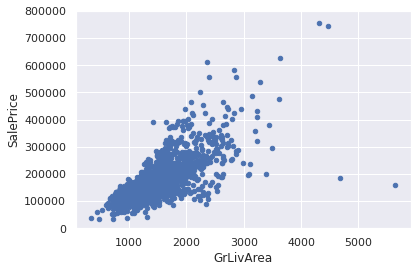

In [23]:
#bivariate analysis saleprice/grlivarea
var = 'GrLivArea'
data = pd.concat([df_train['SalePrice'], df_train[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(0,800000))

We can see that the two highest saleprice values follow the trend, so they are not going to be removed. 

In [24]:
df_train.sort_values(by = 'GrLivArea', ascending = False)[:2]

,Id,MSSubClass,MSZoning,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,ExterQual,ExterCond,Foundation,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,GarageCars,GarageArea,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
1298,1299,60,RL,63887,Pave,IR3,Bnk,AllPub,Corner,Gtl,Edwards,Feedr,Norm,1Fam,2Story,10,5,2008,2008,Hip,ClyTile,Stucco,Stucco,Ex,TA,PConc,5644,0,466,6110,GasA,Ex,Y,SBrkr,4692,950,0,5642,2,0,2,1,3,1,Ex,12,Typ,3,2,1418,Y,214,292,0,0,0,480,0,1,2008,New,Partial,160000
523,524,60,RL,40094,Pave,IR1,Bnk,AllPub,Inside,Gtl,Edwards,PosN,PosN,1Fam,2Story,10,5,2007,2008,Hip,CompShg,CemntBd,CmentBd,Ex,TA,PConc,2260,0,878,3138,GasA,Ex,Y,SBrkr,3138,1538,0,4676,1,0,3,1,3,1,Ex,11,Typ,1,3,884,Y,208,406,0,0,0,0,0,10,2007,New,Partial,184750


In [25]:
#deleting points
df_train = df_train.drop(df_train[df_train['Id'] == 1299].index)
df_train = df_train.drop(df_train[df_train['Id'] == 524].index)

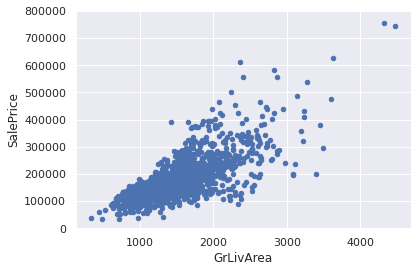

In [26]:
#bivariate analysis saleprice/grlivarea
var = 'GrLivArea'
data = pd.concat([df_train['SalePrice'], df_train[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(0,800000));

We can also now see that the TotalBsmtSF outlier got removed as well.

37

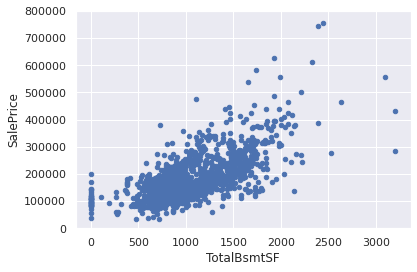

In [27]:
#scatter plot TotalBsmtSF/saleprice
var = "TotalBsmtSF"
data = pd.concat([df_train['SalePrice'], df_train[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(0,800000))
len(df_train[df_train[var] == 0])

# Hair et al. (2013) analysis

Ind oreder to apply multivariate techniques, we must comply with following stat. assumptions:

* Normality: does data look like normal dist. (univarity normality/multivariate normality)
* Homoscedasticity: dependant variable(s) exhibit equal levels of variance across the range of predictor variable(s). We want the error term to be the same across all values of the independant variables.
* Linearity: or else data transformations
* Absence of correlated errors: or else add a variable that can explain the error (fx pos. error in one var. and neg. in another). (special focus on time series)


## Normalize sale price 

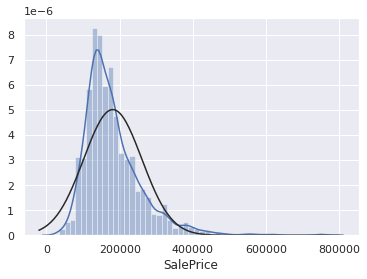

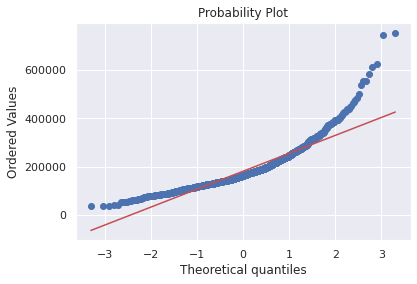

In [28]:
#histogram and normal probability plot
sns.distplot(df_train['SalePrice'], fit=norm);
fig = plt.figure()
res = stats.probplot(df_train['SalePrice'], plot=plt)

Peakedness, pos. skewness and does not follow the diagonal line

We try log(SalePrice) transformation

In [29]:
#applying log transformation
df_train['SalePrice'] = np.log(df_train['SalePrice'])

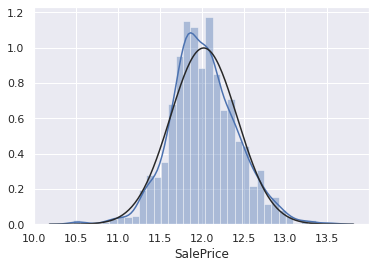

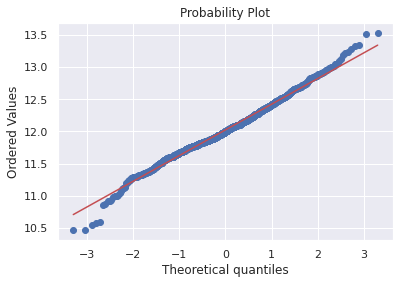

In [30]:
#transformed 
sns.distplot(df_train['SalePrice'], fit=norm);
fig = plt.figure()
res = stats.probplot(df_train['SalePrice'], plot=plt)

## GrLivArea

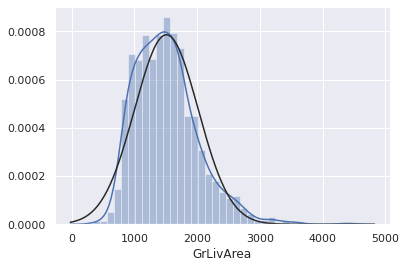

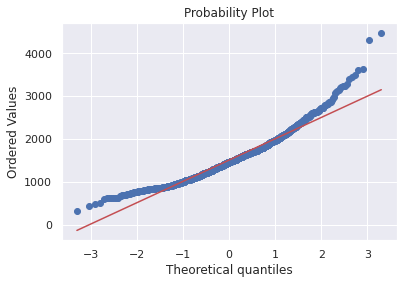

In [31]:
#histogram and normal probability plot
sns.distplot(df_train['GrLivArea'], fit=norm);
fig = plt.figure()
res = stats.probplot(df_train['GrLivArea'], plot=plt)

Log transform as well (peakedness, pos. skewness, does not follow the diagonal.) 

In [32]:
df_train['GrLivArea'] = np.log(df_train['GrLivArea'])

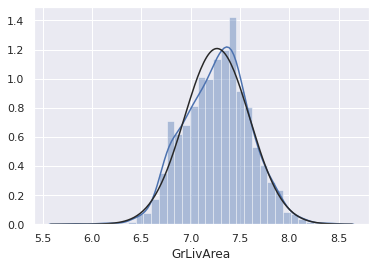

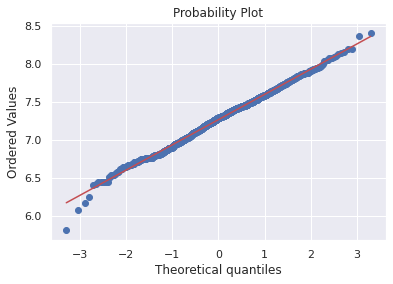

In [33]:
#transformed
sns.distplot(df_train['GrLivArea'], fit=norm);
fig = plt.figure()
res = stats.probplot(df_train['GrLivArea'], plot=plt)

## TotalBsmtSF

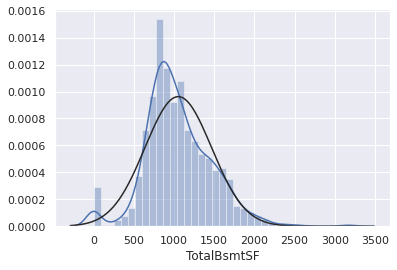

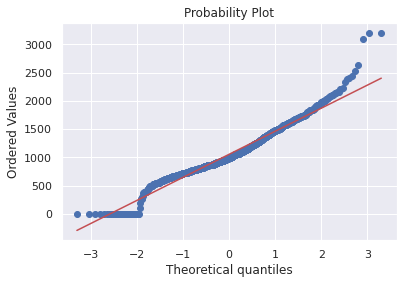

In [34]:
sns.distplot(df_train['TotalBsmtSF'], fit=norm);
fig = plt.figure()
res = stats.probplot(df_train['TotalBsmtSF'], plot=plt)

Challanges here:

* Pos. skewness
* Significant number of obs. with value zero (houses w/o basement) (cannot apply log transform)

Therefore, we are going to introduce a new variable (HasBsmt) to apply log transform to house with basement.

HasBsmt is 1 for observations if TotalBsmtSF > 0, and 0 otherwise

In [35]:
df_train['HasBsmt'] = pd.Series(len(df_train['TotalBsmtSF']), index=df_train.index)
df_train['HasBsmt'] = 0
df_train.loc[df_train['TotalBsmtSF'] > 0, 'HasBsmt'] = 1

In [36]:
df_train.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotArea', 'Street', 'LotShape',
       'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood',
       'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle', 'RoofMatl',
       'Exterior1st', 'Exterior2nd', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'GarageCars', 'GarageArea',
       'PavedDrive', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
       'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'SaleType',
       'SaleCondition', 'SalePrice', 'HasBsmt'],
      dtype='object')

/opt/conda/lib/python3.7/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


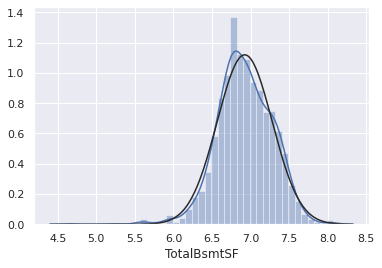

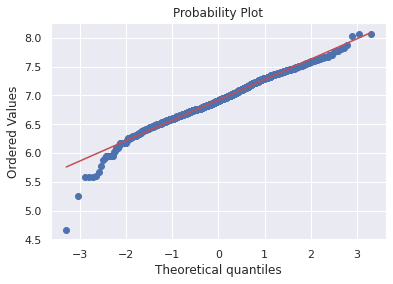

In [37]:
#log transform the TotalBsmtSF, where HasBsmt is true
df_train.loc[df_train['HasBsmt']==1,'TotalBsmtSF'] = np.log(df_train['TotalBsmtSF'])

sns.distplot(df_train[df_train['TotalBsmtSF']>0]['TotalBsmtSF'], fit=norm);
fig = plt.figure()
res = stats.probplot(df_train[df_train['TotalBsmtSF']>0]['TotalBsmtSF'], plot=plt)

# Analysis of homoscedasticity

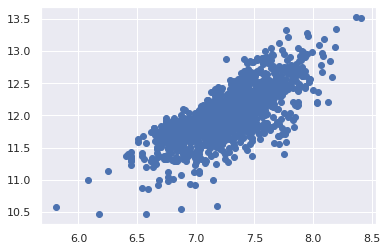

In [38]:
#scatter plot
plt.scatter(df_train['GrLivArea'], df_train['SalePrice']);

The plot shows homoscedasticity (in contrast to previous plot, where normality was not achieved)

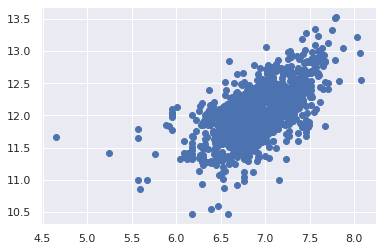

In [39]:
plt.scatter(df_train[df_train['TotalBsmtSF']>0]['TotalBsmtSF'], df_train[df_train['TotalBsmtSF']>0]['SalePrice']);

The amount of error is more or less the same.

# Conversion of cat. var. to dummies

In [40]:
#features
cols = ['OverallQual', 'GrLivArea', 'GarageCars', 'HasBsmt', 'TotalBsmtSF', 'FullBath', 'YearBuilt']
X = df_train[cols]
Y = df_train['SalePrice']

#convert categorical variable into dummy
X = pd.get_dummies(X)

# Training

In [151]:
#train, cross valid. sets
from sklearn.model_selection import train_test_split

train_X, cv_X, train_y, cv_y = train_test_split(X, Y, random_state = 42, test_size = 0.10)


In [152]:
#normalize features
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.pipeline import Pipeline


pipeline = Pipeline([
    ('std_scalar', StandardScaler())
])

train_X = pipeline.fit_transform(train_X)
cv_X = pipeline.transform(cv_X)
test_X = pipeline.transform(test_X)

In [153]:
def cost(py, ry):
    #m = py.shape[0]
    #return 1/(2*m) * np.sum(np.square(py - ry))
    return metrics.mean_squared_log_error(py, ry)

from sklearn import metrics

def print_eval(py, ry):
    mse = metrics.mean_squared_error(py, ry)
    msle = metrics.mean_squared_log_error(py, ry)
    rmsle = np.sqrt(msle)
    r2_square = metrics.r2_score(py, ry)
    print("Mean square error: ", mse)
    print("Root mean square log error (performance target): ", rmsle)
    print("R squared: ", r2_square)

In [154]:
from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression

# For loop for reg. parameter
m = cv_X.shape[0]
exNo = np.zeros(m)
costTrain = np.zeros(m)
costCV = np.zeros(m)

# TO DO
# Cost function vs. examples 
i = 1

_ty = np.exp(train_y)
_cvt = np.exp(cv_y)

while (i <= m):
    model = LinearRegression()
    model.fit(train_X[0:i+10],train_y[0:i+10])
    predT = model.predict(train_X[0:i])
    predCV = model.predict(cv_X)
    exNo[i-1] = i
    costTrain[i-1] = cost(np.exp(predT), _ty[0:i])
    costCV[i-1] = cost(np.exp(predCV), _cvt)
    i+=1

[(0.01482814807135154, 0.0376740370710083)]

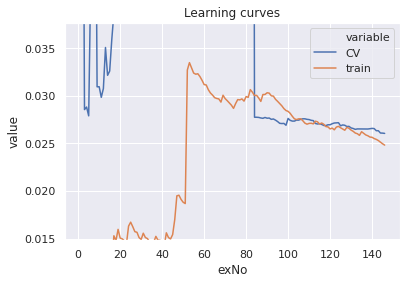

In [158]:
data_preproc = pd.DataFrame({
    'exNo': exNo, 
    'CV': costCV,
    'train': costTrain})

g = sns.lineplot(x='exNo', y='value', hue='variable', 
             data=pd.melt(data_preproc, ['exNo']))
g.set(title="Learning curves")
g.set(ylim=(np.min(data_preproc['train'][90:]-0.01), np.max(data_preproc['CV'][90:]+0.01)))

In [159]:
# CV sets and different models
from sklearn.linear_model import Lasso
from catboost import CatBoostRegressor


def eval_model(model):
    model.fit(train_X,train_y)
    predCV = model.predict(cv_X)
    print_eval(np.exp(predCV), np.exp(cv_y))
    return model

Lin = eval_model(LinearRegression())
Lasoo = eval_model(Lasso(alpha = 0.0005))
catBoost = eval_model(CatBoostRegressor(loss_function='RMSE', silent=True))

Mean square error:  761443670.6793157
Root mean square log error (performance target):  0.15713850322714107
R squared:  0.8022719533813423
Mean square error:  761552882.0839334
Root mean square log error (performance target):  0.15707210665730356
R squared:  0.8009694555191751
Mean square error:  623195187.5169736
Root mean square log error (performance target):  0.143127499848661
R squared:  0.8383134713142727


In [160]:
model = catBoost

predCV = model.predict(cv_X)
print("not relevant (since cv set is included in training set)")
print_eval(np.exp(predCV), np.exp(cv_y))

not relevant (since cv set is included in training set)
Mean square error:  623195187.5169736
Root mean square log error (performance target):  0.143127499848661
R squared:  0.8383134713142727


In [146]:
"""
print("Mean for CV_y and predCV")
print(np.mean(cv_y_exp), np.mean(predCV))
print("Std for CV_y and predCV")
print(np.std(cv_y_exp), np.std(predCV))

sns.distplot((cv_y_exp-predCV), fit=norm)
"""

'\nprint("Mean for CV_y and predCV")\nprint(np.mean(cv_y_exp), np.mean(predCV))\nprint("Std for CV_y and predCV")\nprint(np.std(cv_y_exp), np.std(predCV))\n\nsns.distplot((cv_y_exp-predCV), fit=norm)\n'

# Test set

Apply feature eng. (log and introduce HasBsmt)

In [161]:
df_test = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/test.csv")

cols = ['OverallQual', 'GrLivArea', 'GarageCars', 'HasBsmt', 'TotalBsmtSF', 'FullBath', 'YearBuilt']

#feature eng.
#apply log transform and introduce

df_test['GrLivArea'] = np.log(df_test['GrLivArea'])

df_test['HasBsmt'] = pd.Series(len(df_test['TotalBsmtSF']), index=df_test.index)
df_test['HasBsmt'] = 0

#To deal with a special case where TotalBsmtSF and GarageCars are NaN
df_test.loc[np.isnan(df_test['TotalBsmtSF']), 'TotalBsmtSF'] = 0
df_test.loc[np.isnan(df_test['GarageCars']), 'GarageCars'] = 0

df_test.loc[df_test['TotalBsmtSF'] > 0, 'HasBsmt'] = 1
df_test.loc[df_test['HasBsmt']==1,'TotalBsmtSF'] = np.log(df_test['TotalBsmtSF'])

#missing data
total = df_test[cols].isnull().sum().sort_values(ascending=False)
percent = (df_test[cols].isnull().sum()/df_test[cols].isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

/opt/conda/lib/python3.7/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,Total,Percent
YearBuilt,0,0.0
FullBath,0,0.0
TotalBsmtSF,0,0.0
HasBsmt,0,0.0
GarageCars,0,0.0
GrLivArea,0,0.0
OverallQual,0,0.0


In [162]:
final_X = df_test[cols]
final_X = pipeline.transform(final_X)

#Apply model
#Create a new column with same row no. as others
#df_test['SalePrice'] = pd.Series(len(df_test['GrLivArea']), index=df_test.index)
#Remember to convert to non log dollars
final_y = model.predict(final_X)
final_y = np.exp(final_y)
#df_test['SalePrice'] = np.exp(model.predict(final_X))

In [163]:
df_test['SalePrice'] = pd.Series(len(df_test['GrLivArea']), index=df_test.index)
df_test['SalePrice'] = final_y

In [164]:
submission = pd.DataFrame({
        "Id": df_test['Id'],
        "SalePrice": df_test['SalePrice']
    })
submission.to_csv('submission.csv', index=False)